<a href="https://colab.research.google.com/github/Aglios/651-red-blue-segment-intersection/blob/master/Clippings%202.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install ipdb

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import ipdb

#types and predicates
and tests.  You should include tests after every definition...  

In [0]:
#determinant test; return 1 if r is left of line pq, -1 if r right of line pq, 0 if on line pq
def detTest(px,py,qx,qy,rx,ry):
    D=np.array([[1,px,py],[1,qx,qy],[1,rx,ry]],dtype='i8')
    return int(np.sign(np.linalg.det(D)))
    
#returns true iff pq and rs cross
# JSS: does not handle endpoints on segments consistent with perturbation, but not actually used yet. 

def cross(px,py,qx,qy,rx,ry,sx,sy):
    pqr=detTest(px,py,qx,qy,rx,ry)
    pqs=detTest(px,py,qx,qy,sx,sy)
    if not ((pqr==1 and pqs==-1) or (pqr==-1 and pqs==1)):
        return False
    rsp=detTest(rx,ry,sx,sy,px,py)
    rsq=detTest(rx,ry,sx,sy,qx,qy)
    if not ((rsp==1 and rsq==-1) or (rsp==-1 and rsq==1)):
        return False
    return True

### tests
For example, timing shows that this is about 30 time slower than if you just calculated the numerical value of the determinant and 10 times slower than computing its sign. (Python fuction calls are slow.)  
You don't want to do anything about this now, because you want to get it working first, but if you leave the testing here you'll remember that this is a point to speed up, and the tests will help quickly catch any errors you introduce while doing so. 

In [7]:
import timeit
timeit.timeit('for n in range(50): detTest(1,2,3,4,n,5)', setup="from __main__ import detTest", number = 10000)


6.0696070529998

In [8]:
def mydet(px,py,qx,qy,rx,ry):
  return (qx-px)*(ry-py)-(qy-py)*(rx-px)

timeit.timeit('for n in range(50): mydet(1,2,3,4,n,5)', setup="from __main__ import mydet", number = 10000)

0.1965264059999754

In [9]:
timeit.timeit('for n in range(50): sign(mydet(1,2,3,4,n,5))', setup="from __main__ import mydet; from numpy import sign", number = 10000)

0.5656986039998628

Quick test for segments with co-linear points. I'm just going to include comments on the expected test results, but I am certain that there are python packages that give more elegant test rigs. 

In [10]:
# test with 3 or 4 points on a line (currently all False, but some should perhaps be True)
print(cross(0,0, 2,2, 1,1, 4,4), cross(0,0, 2,2, 1,0, 3,4), cross(0,0, 2,2, 1,-1, -1,1)) # all print as false

False False False


## Point, segment, and flag types

In [0]:
#class for points
class Point:
    def __init__(self, x, y):
        self.x=x
        self.y=y
    def plot(self):
        plt.scatter(self.x,self.y)
        return self
        
    def prt(self):
        print((self.x,self.y))
        return self # JSS: useful because you can insert prt anywhere...
            
    def __lt__(self,other):
        return self.x<other.x or (self.x==other.x and self.y<other.y)        
    def __gt__(self,other):
        return self.x>other.x or (self.x==other.x and self.y>other.y)    
    def __eq__(self,other):
        return self.x==other.x and self.y==other.y    
    def __le__(self,other):
        return self.x<other.x or (self.x==other.x and self.y<=other.y)    
    def __ge__(self,other):
        return self.x>other.x or (self.x==other.x and self.y>=other.y)   
    def __ne__(self,other):
        return not (self==other)



In [12]:
print(Point(1,2) < Point(1,3), Point(1,2) == Point(1.0,2.0), Point(0,1)<Point(1,2)) # all True

True True True


In [0]:
#class for segments 
#color is 0 for red, 1 for blue
RBCOLOR = 'rb' #JSS: tiny tables are better than copying code to avoid copy paste errors and save memory
REDBLUE = ['red','blue']

#invariant:  p<=q lexicographically # JSS: always comment on invariants.
class Segment:
    def __init__(self,pointA,pointB,color):
        if pointA<pointB:
            self.p=pointA
            self.q=pointB
        else:
            self.p=pointB
            self.q=pointA
        self.color=color
    
    def prt(self):
        print((self.p.x,self.p.y), (self.q.x,self.q.y), REDBLUE[self.color])
        return self
    
    def cmpPt(self,p):
        return detTest(self.p.x,self.p.y,self.q.x,self.q.y,p.x,p.y)
    
    # JSS: does not handle colinear case or crossing cases
    def cmp(self,other):
        assert self.color==other.color  # JSS: assumes segments are the same color, so lets assert it
        sp=other.cmpPt(self.p)
        sq=other.cmpPt(self.q)
        if sp*sq<0:
            sp=self.cmpPt(other.p)
            sq=self.cmpPt(other.q)
            if sp==0:
                return sq
            return sp
        if sp==0:
            return sq
        return sp
    
  #  def cross(self,segB): # JSS: not used
  #      return cross(self.p.x,self.p.y,self.q.x,self.q.y,segB.p.x,segB.p.y,segB.q.x,segB.q.y)
    
    def equals(self,other):
        return self.p==other.p and self.q==other.q and self.color==other.color
          
    def slope(self):
        if (self.q.x-self.p.x)==0: # JSS: IEEE 754 specifies that division by zero gives +/-Inf, so this test is not needed. 
            return float('inf') 
        else:
            return (self.q.y-self.p.y)/(self.q.x-self.p.x)

    def plot(self):
         plt.plot([self.p.x,self.q.x],[self.p.y,self.q.y],RBCOLOR[self.color])


    #ordered by aboveness (no intersections)
    #should only compare same colored segs
    def __lt__(self,other):
        return self.cmp(other)<0
    def __gt__(self,other):
        return self.cmp(other)>0
    def __eq__(self,other): # JSS: this is not an equality test but a colinearity test. Ignores color.
        if other==None:
            return False
        return self.cmp(other)==0
    def __le__(self,other):
        return self.cmp(other)<=0
    def __ge__(self,other):
        return self.cmp(other)>=0
    def __ne__(self,other):
        return not self==other
    
            



In [14]:
s0022 = Segment(Point(0,0), Point(2,2), 0).prt() # red
s4411 = Segment(Point(4,4), Point(1,1), 1).prt() # blue
s3344 = Segment(Point(3,3), Point(4,4), 0).prt() # red
s0322 = Segment(Point(0,3), Point(2,2), 0).prt() # red
s0244 = Segment(Point(0,2), Point(4,4), 1).prt() # blue
print(s0022==s3344) # should not be true #SM: tests for collinearity
print(s0244 > s4411, s0322>s0022 ) # should be true
# s3344 == s4411# can't test these of opposite color

(0, 0) (2, 2) red
(1, 1) (4, 4) blue
(3, 3) (4, 4) red
(0, 3) (2, 2) red
(0, 2) (4, 4) blue
True
True True


In [0]:
#flags are made from a segment and a endpoint of the segment
#0 is for startpt, 1 is for endpt
class Flag:
    def __init__(self, segment, endpoint):
        self.seg=segment
        self.pt=endpoint
        if self.pt==self.seg.p:
            self.type=0
        elif self.pt==self.seg.q:
            self.type=1
        else:
            raise NameError('point is not an endpoint of segment')    
            
    def prt(self):
        self.pt.prt()
        self.seg.prt()
        return self
    
    def slope(self):
        return self.seg.slope()
    
    #assume: segments are broken so that no endpoint of one lies inside another.
    #        flags are compared only with segments that overlap the interval before (for start flags)
    #              or after (for terminal flags) the endpoint.  
    def cmpSeg(self,seg):
        if seg.cmpPt(self.pt)<0:  # JSS: fix to avoid recomputing comparison
            return -1
        elif seg.cmpPt(self.pt)>0:
            return 1
        else: # JSS: depends on overlap assumption.
            if self.slope()==seg.slope():
                return self.seg.color-seg.color # JSS: depends on color = 0 or 1 to give -1, 0, or 1
            else:
              return 1 if ((self.slope()>seg.slope()) == (self.type==0)) else -1 # JSS: this will recompute slope -- rewrite to avoid that
              
#JSS: need a complete set of test cases for this cmp function
    def cmp(self, flagB):
        if self.pt<(flagB.pt):
            return -1
        elif self.pt>(flagB.pt):
            return 1
        else: # process all terminals before all starts
            if self.type != flagB.type:
                return flagB.type - self.type # -1 or 1
            else: # process segs top to bottom
                sign=1
                if self.type==1:
                    sign=-1
                slopeDiff=sign*(self.seg.slope()-flagB.seg.slope())
                if slopeDiff<0:
                    return -1
                elif slopeDiff>0:
                    return 1
                else: # process (blue above red) #  SM: process "below" first
                    return self.seg.color-flagB.seg.color

               
    def __lt__(self,other):
        return self.cmp(other)<0
    def __gt__(self,other):
        return self.cmp(other)>0
    def __eq__(self,other):
        return self.cmp(other)==0
    def __le__(self,other):
        return self.cmp(other)<=0
    def __ge__(self,other):
        return self.cmp(other)>=0
    def __ne__(self,other):
        return self.cmp(other)!=0 

In [16]:
f441 = Flag(s4411, s4411.q).prt()
f443 = Flag(s3344, s3344.q).prt()
f442 = Flag(s0244, s0244.q).prt()
f002 = Flag(s0022, s0022.p).prt()
f114 = Flag(s4411, s4411.p).prt()
print('f002<f441', f002.cmp(f441))
print(f002<f441) # true
print('f441<f442', f441.cmp(f442), 'and f442>f443', f442.cmp(f443), 'and f441>f443', f441.cmp(f443))
print(f441<f442 and f442>f443 and f441>f443) # true  #SM: s4411 automatically changed to s4411

(4, 4)
(1, 1) (4, 4) blue
(4, 4)
(3, 3) (4, 4) red
(4, 4)
(0, 2) (4, 4) blue
(0, 0)
(0, 0) (2, 2) red
(1, 1)
(1, 1) (4, 4) blue
f002<f441 -1
True
f441<f442 -1 and f442>f443 1 and f441>f443 1
True


# Splay tree
We use a splay tree, implemented in the following code for `Node` and for `Tree`.  

## Node 
A node has a `val` (which will be segment in our application), and pointers to its `parent`, and `left` & `right` children, possibly `None`.  

In [0]:
class Node:
    #SM
    def __init__(self,seg, parent=None, left=None, right=None):
        self.seg=seg
        self.parent=parent
        self.left=left
        self.right=right
    
    def prt(self): # print node alone
        print('[Node:', self.seg, self.parent, self.left, self.right, ']' )
        return self

## Tree
The tree holds the `root` node and the `min` and `max` vals.
Only the root has `parent=None`.   This is actually violated by `split` and before `join`.  
Our trees are also in a doubly linked list (`abv` and `bel`) that alternates colors. (This is perhaps overspecializing the tree. The way you implement maintenance for `min` and `max`, you could make a bundle class that has a tree.)  I see that you have abv/bel in your bundle structure, so I'm taking them and color

In [0]:
class Tree:
    def __init__(self,node,minSeg=None,maxSeg=None):
        #SM: moved color, abv, bel to Bundle,
        self.root=node
        if minSeg!=None:
            self.min=minSeg
        else:
            self.min=self.findMin(self.root).seg
        
        if maxSeg!=None:
            self.max=maxSeg
        else:
            self.max=self.findMax(self.root).seg
        
    # operations on a tree node
    # Splaying node x move x to the root of the tree
    def __splay(self, x):
        while x.parent != None:
            if x.parent.parent == None:
                if x == x.parent.left:
                    # zig rotation
                    self.__right_rotate(x.parent)
                else:
                    # zag rotation
                    self.__left_rotate(x.parent)
            elif x == x.parent.left and x.parent == x.parent.parent.left:
                # zig-zig rotation
                self.__right_rotate(x.parent.parent)
                self.__right_rotate(x.parent)
            elif x == x.parent.right and x.parent == x.parent.parent.right:
                # zag-zag rotation
                self.__left_rotate(x.parent.parent)
                self.__left_rotate(x.parent)
            elif x == x.parent.right and x.parent == x.parent.parent.left:
                # zig-zag rotation
                self.__left_rotate(x.parent)
                self.__right_rotate(x.parent)
            else:
                # zag-zig rotation
                self.__right_rotate(x.parent)
                self.__left_rotate(x.parent)
        return x # JSS: useful for testing...
                
    #input: node
    #output: minimum node in its subtree
    def findMin(self,node):
        if node.left!=None:
            return self.findMin(node.left)
        else:
            self.__splay(node)
            return node
    
    def findMax(self,node):
        if node.right!=None:
            return self.findMax(node.right)
        else:
            self.__splay(node)
            return node
    
    def successor(self, x):
        # if the right subtree is not null,
        # the successor is the leftmost node in the
        # right subtree
        if x.right != None:
            return self.findMin(x.right) #JSS: odd that we splay in only one half of the if

        # else it is the lowest ancestor of x whose
        # left child is also an ancestor of x.
        y = x.parent
        while y != None and x == y.right:
            x = y
            y = y.parent
        return y

    # find the predecessor of a given node
    def predecessor(self, x):
        # if the left subtree is not null,
        # the predecessor is the rightmost node in the 
        # left subtree
        if x.left != None:
            return self.findMax(x.left)

        y = x.parent
        while y != None and x == y.left:
            x = y
            y = y.parent
        return y
      
    # insert a seg into the tree
    def insert(self, seg):
        y = None
        x = self.root

        while x != None:
            y = x
            if seg < x.seg:
                x = x.left
            else:
                x = x.right
        
        node = Node(seg, y)
        if y == None: 
            self.root = node
        elif node.seg < y.seg:
            y.left = node
        else:
            y.right = node
        # splay the node
        self.__splay(node)
        
        if seg>self.max:
            self.max=seg
        if seg<self.min:
            self.min=seg
            
        assert self.root==node
        return seg
      

    #input: root node it is searching in, seg
    #output: node in tree containing the seg
    def __findHelper(self,node,seg):
        if seg<node.seg:
            if node.left==None:
                raise NameError("seg not in tree")
            return self.__findHelper(node.left,seg)
        elif seg>node.seg:
            if node.right==None:
                raise NameError("seg not in tree")
            return self.__findHelper(node.right,seg)
        else:
            return node
    
    #input:segue
    #output: node containing the seg
    def find(self,seg):
        if self.root==None:
            raise NameError("empty tree")
        node=self.__findHelper(self.root,seg)
        self.__splay(node)
        assert self.root==node
        return node
    
    def isIn(self,seg):
        try:
            self.find(seg)
            return True
        except NameError:
            return False
    
       
    # this is a tree operation, because it may change root, as well as a node.
    # Since rotation is used only in splay, however, it is not required to maintain the root here; splay could reset it.
    def __left_rotate(self, x):
        y = x.right
        x.right = y.left
        if y.left != None:
            y.left.parent = x

        y.parent = x.parent
        if x.parent == None:
            self.root = y
        elif x == x.parent.left:
            x.parent.left = y
        else:
            x.parent.right = y
        y.left = x
        x.parent = y

    # rotate right at node x
    def __right_rotate(self, x):
        y = x.left
        x.left = y.right
        if y.right != None:
            y.right.parent = x
        
        y.parent = x.parent;
        if x.parent == None:
            self.root = y
        elif x == x.parent.right:
            x.parent.right = y
        else:
            x.parent.left = y
        y.right = x
        x.parent = y
    
    #SM: __joinNodes and __splitNode do not change self.max and self.min; The functions that use them change them
    
    #SM:changed to joinNodes
    #input: node2, everything in self is smaller than the tree of node
    #output: one node that is the merge of them
    def __joinNodes(self,node2):
        if self.root==None:
            self.root=node2
            return self.root
        if node2==None:
            return self.root
        
        node=self.findMax(self.root) #already splayed
        assert self.root==node
        node.right=node2
        node2.parent=node
        return node
    
    #input: segue of node to split at; must be in the tree. 
    #output: root nodes of two trees, everything in node1 is less than or equal to node; subtree of rightroot is greater
    #JSS: found node is placed at the root of tree, with no right child.
    def __splitNode(self,seg):
        node=self.find(seg)   #find the node and splay to top
        assert self.root==node
        if node.right!=None:
            rightroot=node.right
            rightroot.parent=None
        else:
            rightroot=None
        node.right=None
        return [node,rightroot]

    #input:seg
    #output:self if successfully deleted
    def delete(self,seg):
        [segnode,rightroot]=self.__splitNode(seg)
        if segnode.left != None:
            self.root=segnode.left
            self.root.parent=None
            self.__joinNodes(rightroot)
        elif segnode.left==None and rightroot!=None: 
            self.root=rightroot
        elif segnode.left==None and rightroot==None:
            self.max=None
            self.min=None
            return self
        
        if seg==self.max: #SM: added splay to findMax/Min 
            self.max=self.findMax(self.root).seg
        if seg==self.min:
            self.min=self.findMin(self.root).seg
        return self
        
        
    #input: other tree, self<other, no empty trees
    #output: other tree merged into self
    #SM: change other tree to have same seg as self
    def joinTrees(self,other):
        assert self.max<other.min
        node=self.__joinNodes(other.root)
        self.max=other.max
        return self
        
    #input: seg to make the split
    #output: two trees
    def splitTree(self,seg):
        [node1,node2]=self.__splitNode(seg)      
        return [Tree(node1,self.min,seg),Tree(node2,None,self.max)]
    
    def __in_order_helper(self, node, segList):
        if node != None:
            self.__in_order_helper(node.left,segList)
            segList.append(node.seg)
            self.__in_order_helper(node.right,segList)
    
    # In-Order traversal
    # Left Subtree -> Node -> Right Subtree
    def inorder(self):
        segList=[]
        self.__in_order_helper(self.root,segList)
        return segList
        
    def __print_helper(self, currPtr, indent, last):
            # print the tree structure on the screen
            if currPtr != None:
                sys.stdout.write(indent)
                if last:
                    sys.stdout.write("└──")
                    indent += "     "
                else:
                    sys.stdout.write("├──")
                    indent += "|    "

                print (currPtr.seg)

                self.__print_helper(currPtr.right, indent, False)
                self.__print_helper(currPtr.left, indent, True)

    # print the tree structure on the screen
    def pprint(self):
        if self.root != None:
            #if self.color == None:
              print('Tree ', self.min, self.root.seg, self.max) # JSS
            #else:
            #  print(REDBLUE[self.color], 'Tree ', self.min, self.root.seg, self.max) # JSS
        self.__print_helper(self.root, "", True)

In [19]:
nd = Node(1)
nd.prt()
t = Tree(Node(0))
t.insert(3)
t.insert(5)
t.insert(4)
t.pprint()
t.insert(1)
t.pprint()
t.find(5)
t.insert(2)
t.pprint()
t.delete(0)
t.pprint()
t.delete(1)
t.pprint()
t.delete(5)
t.pprint()

[Node: 1 None None None ]
Tree  0 4 5
└──4
     ├──5
     └──3
          └──0
Tree  0 1 5
└──1
     ├──4
     |    ├──5
     |    └──3
     └──0
Tree  0 2 5
└──2
     ├──4
     |    ├──5
     |    └──3
     └──1
          └──0
Tree  1 1 5
└──1
     ├──2
     |    ├──4
     |    |    ├──5
     |    |    └──3
Tree  2 2 5
└──2
     ├──4
     |    ├──5
     |    └──3
Tree  2 4 4
└──4
     └──2
          ├──3


In [20]:
tree=Tree(Node(33))
tree.insert(67)
tree.insert(44)
tree.insert(5)
tree.insert(112)
tree.insert(143)
tree.insert(165)
tree.insert(150)
l=tree.inorder()
print(l)
tree.pprint()

[treeA,treeB]=tree.splitTree(143)
treeA.pprint()
treeB.pprint()
treeA.joinTrees(treeB)
treeA.pprint()
treeB.pprint()

[5, 33, 44, 67, 112, 143, 150, 165]
Tree  5 150 165
└──150
     ├──165
     └──143
          └──112
               └──33
                    ├──67
                    |    └──44
                    └──5
Tree  5 143 143
└──143
     └──112
          └──33
               ├──67
               |    └──44
               └──5
Tree  150 150 165
└──150
     ├──165
Tree  5 143 165
└──143
     ├──150
     |    ├──165
     └──112
          └──33
               ├──67
               |    └──44
               └──5
Tree  150 150 165
└──150
     ├──165


In [21]:
tree=Tree(Node(2))
tree.insert(1)
tree.insert(3)
tree.delete(2)
tree.pprint()

Tree  1 1 3
└──1
     ├──3


In [0]:
#SM:reworked bundle class: self.tree, abv, bel are all pointers. color is constant
#JSS: not needed; reverted to names. 
#all the abv bel changes are done in BundleList
class Bundle:
    def __init__(self,tree=None,abv=None,bel=None):
        self.tree=tree
        if tree == None:
          self.color = None
        else:
          self.color = tree.root.seg.color
        self.abv=abv
        self.bel=bel
    
    
    def __flagTestHelper(self,node,flag):
        cmp=flag.cmpSeg(node.seg)
        if cmp<0:
            if node.left==None:
                return [node,-1]
            return self.__flagTestHelper(node.left,flag)
        elif cmp>0:
            if node.right==None:
                return [node,1]
            return self.__flagTestHelper(node.right,flag)
        else:
            return [node,0]
    
    #input: flag
    #output: a node directly above or below it with indication (0:flag on seg, -1:flag below, 1:flag above)
    def flagTest(self,flag):
        return self.__flagTestHelper(self.tree.root,flag)
    
    #input: other bundle(nonempty)
    #output: self.tree joined with other.tree, changed in both bundles
    def join(self,other):
        #A<self<other<B
        assert self.color==other.color
        self.tree=self.tree.joinTrees(other.tree)
        
        #copy self to other
        other.tree=self.tree
        return self
    
    def insert(self,seg):
        assert seg.color==self.color
        return self.tree.insert(seg)
    
    def delete(self,seg):
        self.tree.delete(seg) #SM:operation done in BundleList
        return self
    
    #input: flag, direc direction to include 
    #output: splits the tree at the flag
    def split(self,flag,direc):
        #A<self<B to A<b1<b2<B
        
        [node,d]=self.flagTest(flag)
        if d==-1:
            node=self.tree.predecessor(node)
            [t1,t2]=self.tree.splitTree(node.seg)
        elif d==1:
            [t1,t2]=self.tree.splitTree(node.seg)
        else:
            if self.tree.root.left==None and self.tree.root.right==None:
                return [self,self]
            elif direc==1:
                node=self.tree.predecessor(node)
                [t1,t2]=self.tree.splitTree(node.seg)
            else:
                [t1,t2]=self.tree.splitTree(node.seg)
        
        b1=Bundle()
        b1.tree=t1
        b1.color=self.color
        
        b2=Bundle()
        b2.tree=t2
        b2.color=self.color
        return [b1,b2]
    
    def isIn(self,seg):
        return self.tree.isIn(seg)
    def max(self):
        return self.tree.max
    def min(self):
        return self.tree.min
    def color(self):
        return self.tree.color
    def isEmpty(self):
        if self.tree.root==None:
            return True
        return False
    
    def plot(self):
        l=self.tree.inorder()
        for i in range(len(l)):
            l[i].prt()
            l[i].plot()
        print(' ')
        plt.axis('equal')

(0, 0) (5, 5) red
(0, 0) (4, 5) red
 


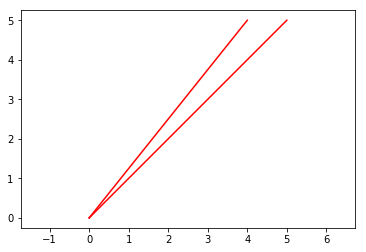

In [27]:
#testing insert, delete, split
def makeSeg(px,py,qx,qy,col):
    return Segment(Point(px,py),Point(qx,qy),col)

def makeFlag(seg,typ):
    if typ==0:
        return Flag(seg,seg.p)
    return Flag(seg,seg.q)

r0055=makeSeg(0,0,5,5,0)
r0045=makeSeg(0,0,4,5,0)
r1044=makeSeg(1,0,4,4,0)
tree=Tree(Node(r0055))
tree.insert(r0045)
tree.insert(r1044)
bundle=Bundle(tree)
#bundle.plot()
#bundle.delete(r1044)
#bundle.plot()

r1044t=makeFlag(r1044,0)
[b1,b2]=bundle.split(r1044t,0)
b2.plot()

(1, 1) (2, 2) red
(1, 1) (2, 3) red
 
(1, 1) (2, 3) red
 


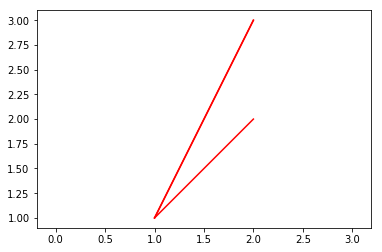

In [32]:
#testing join pointers
#JSS:  I don't like this because you need to use all of your classes.
# You should assume that someone gives you a collection of segs, all of the same color and in the right order, 
# and you may want to make a bundle from them.  Bundle should just add them to the tree.
def makeSegBundle(px,py,qx,qy,col):
    seg=Segment(Point(px,py),Point(qx,qy),col)
    node=Node(seg)
    tree=Tree(node,seg,seg)
    return Bundle(tree)

def makeFlag(px,py,qx,qy,col,typ):
    seg=makeSeg(px,py,qx,qy,col)
    if typ==0:
        return Flag(seg,seg.p)
    return Flag(seg,seg.q)


a=makeSegBundle(1,1,2,2,0)
a.bel=makeSegBundle(0,0,1,1,0)

b=makeSegBundle(1,1,2,3,0)
b.abv=makeSegBundle(0,0,1,2,0)

keep=b

a.join(b)
a.plot()
b.delete(makeSeg(1,1,2,2,0))
a.plot()

a.bel=makeSegBundle(9,9,9,9,0)
a.tree=None
keep.tree

## Processing a flag


### Processing the point (with slope)

Find the point in the red list:
    
    Look through the red bundles, locate which bundle it is in or which two red bundles it is between
    
Ensure the point is in between two red bundles
    
    If it already is, good; if it is inside red bundle, split it. Keep track of them.

Look for the point in the adjacent blue bundles 
    
    Check between the red bundles, above the upper red bundle, and below the lower red bundle
    
If it's not in the adjacent blue bundles.
    
    Swap and merge appropriately
    
Check if it is in the adjacent blue bundle (only need to check one red), if not, swap bundles; continue until it is in an adjacent blue bundle

Split blue bundle

Swap
    

### Processing the segment

If adding the segment:
    
    add the segment as a bundle or into a bundle
    
if removing the segment:

    Check if the appropriate segment is in the proper position (since when splitting the segment goes to the bottom bundle).
    If not, add the appropriate intersections.
    Remove point.
    

In [0]:
#split first, then do the merge/swaps
#6 cases, state which case you are in

def makeSegBundle(px,py,qx,qy,col):
    seg=Segment(Point(px,py),Point(qx,qy),col)
    node=Node(seg)
    tree=Tree(node,seg,seg)
    return Bundle(tree)

def makeFlag(px,py,qx,qy,col,typ):
    seg=makeSeg(px,py,qx,qy,col)
    if typ==0:
        return Flag(seg,seg.p)
    return Flag(seg,seg.q)

#BundleList itself holds red bundles
class BundleList:
    def __init__(self,rang): # JSS: blue over red
        redLow=makeSegBundle(-rang,-rang,rang,-rang,0)
        
        blueLow=makeSegBundle(-rang,-rang,rang,-rang,1)
        blueLow.bel=redLow
        redLow.abv=blueLow
        
        redHigh=makeSegBundle(-rang,rang,rang,rang,0)
        redHigh.bel=blueLow
        blueLow.abv=redHigh
        
        blueHigh=makeSegBundle(-rang,rang,rang,rang,1)
        blueHigh.bel=redHigh
        redHigh.abv=blueHigh
        
        
        self.lowest=redLow
        self.highest=blueHigh
    
    def plot(self):
        cur=self.lowest
        while cur.abv!=None:
            cur.plot()
            cur=cur.abv
        cur.plot()
        plt.show()
    
    
    #input: flag
    #output: red bundle directly below the flag or the bundle encompassing it
    #JSS: it is enough to test the min for this result. You'll need to look at the max in the return anyways.
    def findFlag(self,flag):
        cur=self.lowest
        #invariant: cur is a red bundle that's below the flag
        while cur.abv.abv!=None and flag.cmpSeg(cur.abv.abv.min())>=0:
            cur=cur.abv.abv
        return cur
    
    #input:bundle to swap, 
    #output: if d==1 swap up, d==0 swap down; joins nearby same colored bundles
    def __swap(self,bundle,d):
        #bottom, a, b, top; to bottom, b, a, top
        if d==1:
            a=bundle
            b=bundle.abv
        else:
            a=bundle.bel
            b=bundle
        assert a.color()!=b.color()
        bottom=a.bel
        top=b.abv
        # JSS: report intersections
        bottom.abv=b
        b.bel=bottom

        b.abv=a
        a.bel=b

        a.abv=top
        top.bel=a
        if a.color()==top.color():
            a = self.__join(top) 
        if b.color()==bottom.color():
            self.__join(b)
        
        if d==1:
            return a
        else:
            return b
            
    
    #input:bundle that is splitting, flag to split at
    #output: splits the bundle
    def __split(self,bundle,flag,d):
        return self # stub
    
    #input:bundle, d the direction it is joining  # JSS: you don't need to do that. Just pass the higher.
    #output: d==1: join with Higher, else join with lower
    def __join(self,bundle):
        bb = bundle.bel.bel
        bundle.join(bundle, bundle.bel)
        bundle.bel = bb
        return bundle
        
    #JSS: can we avoid the duplication of checkHigher/checkLower by always starting with the lower bundle and merging up?
    #input: bundle, flag
    #output: return 0 if flag is above bundle.abv.max, return 1 if not, return 2 if flag is inside bundle.abv
    def __checkHigher(self,bundle,flag):
        if bundle.abv==None:
            return 1
        
        above=bundle.abv 
        if flag.cmpSeg(above.max())>0:
            return 0
        elif flag.cmpSeg(above.min())>=0:
            return 2
        else:
            return 1
          
    def __checkLower(self,bundle,flag):
        if bundle.bel==None:
            return 1
        
        below=bundle.bel
        if flag.cmpSeg(below.min())<0:
            return 0
        elif flag.cmpSeg(below.max())<=0:
            return 2
        else:
            return 1
    
    #input: bundle
    #output: removes the bundle from the bundleList if the bundle is empty
    def __removeBundle(self,bundle):
        if bundle.isEmpty():
            bot=bundle.bel
            top=bundle.abv
            bot.abv=top
            top.bel=bot
            self.__join(bot,1)
            return True
        return False
    
    #decide the where to include equality segments by knowing whether it is swapping up or down
    def __process1(self,flag):
        bundle=self.findFlag(flag)
        #print("bundle it's in")
        #bundle.plot()
        if flag.cmpSeg(bundle.max())>0:
            redLow=bundle
            redHigh=bundle.abv.abv
        else:
            blueAbv=bundle.abv
            blueBel=bundle.bel
            tf=True
            if flag.cmpSeg(blueAbv.min())>=0:
                [redLow,redHigh]=self.__split(bundle,flag,1)
                tf=False
            if flag.cmpSeg(blueBel.max())<=0:
                [redLow,redHigh]=self.__split(bundle,flag,0)
                assert tf
        
        assert self.__checkHigher(redHigh,flag)!=0 or self.__checkLower(redLow,flag)!=0
        
        while self.__checkHigher(redHigh,flag)==0:
            redHigh=self.__swap(redHigh,1)
            
        while self.__checkLower(redLow,flag)==0:
            redLow=self.__swap(redLow,0)
            
        cu=self.__checkHigher(redHigh,flag)
        cl=self.__checkLower(redLow,flag)
        assert cu!=0 and cl!=0
        
        if cu==2:
            print('cu=2')
            [blueLow,blueHigh]=self.__split(redHigh.abv,flag,0)
            self.__swap(blueLow,0)
            assert blueLow.abv is redHigh
        elif cl==2:
            print('cl=2')
            [blueLow,blueHigh]=self.__split(redLow.bel,flag,1)
            self.__swap(blueHigh,1)
            #ipdb.set_trace()
            assert blueHigh.bel is redLow
        elif redLow.abv.abv is redHigh:
            print('cu=cl=1, one blue bundle in between')
            blue=redLow.abv
            if flag.cmpSeg(blue.max())<=0 and flag.cmpSeg(blue.min())>=0:
                [blueLow,blueHigh]=self.__split(blue,flag,0)
            elif flag.cmpSeg(blue.max())>0:
                blueLow=blue
                blueHigh=blue.abv.abv
            else:
                blueLow=blue.bel.bel
                blueHigh=blue
        elif redLow.abv is redHigh:
            print('cu=cl=1, red bundles together')
            blueLow=redLow.bel
            blueHigh=redHigh.abv
        else:
            print('cu=cl=1')
            blueLow=redHigh.bel
            blueHigh=redHigh.abv
            if flag.cmpSeg(blueLow.max())<0 or flag.cmpSeg(blueHigh.bel)>=0:
                blueLow=redLow.bel
                blueHigh=redHigh.abv
        assert redLow.color()==0 and redHigh.color()==0 and blueLow.color()==1 and blueHigh.color()==1
        
        return [redLow,redHigh,blueLow,blueHigh]
    
    
    def processFlag(self,flag):
        [redLow,redHigh,blueLow,blueHigh]=self.__process1(flag)
        fc=flag.seg.color
        if flag.type==0:
            if blueLow.abv is redHigh:
                #print('blueLow.abv is redHigh')
                if fc==0:
                    redHigh.insert(flag.seg)
                else:
                    blueLow.insert(flag.seg)
            elif redLow.abv is blueHigh:
                #print('redLow.abv is blueHigh')
                if fc==0:
                    redLow.insert(flag.seg)
                else:
                    blueHigh.insert(flag.seg)
            elif blueLow.abv is blueHigh:
                #print('blueLow.abv is blueHigh')
                if fc==0:
                    newR=Bundle(flag.seg)
                    blueLow.abv=newR
                    newR.bel=blueLow
                    
                    newR.abv=blueHigh
                    blueHigh.bel=newR
                else:
                    blue=self.__join(blueLow,1)
                    blue.insert(flag.seg)
            elif redLow.abv is redHigh:
                #print('redLow.abv is redHigh')
                if fc==1:
                    newB=Bundle(flag.seg)
                    redLow.abv=newB
                    newB.bel=redLow
                    
                    newB.abv=redHigh
                    redHigh.bel=newB
                else:
                    red=self.__join(redLow,1)
                    red.insert(flag.seg)
            else:
                raise NameError("problem with process1")
        else:
            if redLow.isIn(flag.seg):
                redLow.delete(flag.seg)
                self.__removeBundle(redLow)
            elif redHigh.isIn(flag.seg):
                redHigh.delete(flag.seg)
                self.__removeBundle(redHigh)
            elif blueLow.isIn(flag.seg):
                blueLow.delete(flag.seg)
                self.__removeBundle(blueLow)
            elif blueHigh.isIn(flag.seg):
                blueHigh.delete(flag.seg)
                self.__removeBundle(blueHigh)
            else:
                raise NameError("problem with process1")
        

In [0]:
#for building segments
class AllSegments:
    def __init__(self):
        self.red=[]
        self.blue=[]
        self.flags=[]
    #adding segments 
    def addRed(self,px,py,qx,qy):
        self.red.append(Segment(Point(px,py),Point(qx,qy),0))
    def addBlue(self,px,py,qx,qy):
        self.blue.append(Segment(Point(px,py),Point(qx,qy),1))
    
    #create square with endpts (-x,-x), (-x,x), (x,-x), (x,x)
    def addRedSq(self,x):
        self.addRed(-x,-x,-x,x)
        self.addRed(-x,-x,x,-x)
        self.addRed(x,x,x,-x)
        self.addRed(x,x,-x,x)
    
    def partition(self,arr,low,high): 
        i = ( low-1 )         
        pivot = arr[high]      
        for j in range(low , high):      
            if   arr[j].cmp(pivot)<=0:             
                i = i+1 
                arr[i],arr[j] = arr[j],arr[i] 
        arr[i+1],arr[high] = arr[high],arr[i+1] 
        return ( i+1 ) 

    def quickSort(self,arr,low,high): 
        if low < high: 
            pi = self.partition(arr,low,high) 
            self.quickSort(arr, low, pi-1) 
            self.quickSort(arr, pi+1, high)

    def sort(self,arr):
        self.quickSort(arr,0,len(arr)-1)

    #return the sorted list of flags
    def sortFlags(self):
        self.flags=[]
        for i in range(len(self.red)):
            self.flags.append(Flag(self.red[i],self.red[i].p))
            self.flags.append(Flag(self.red[i],self.red[i].q))
        for i in range(len(self.blue)):
            self.flags.append(Flag(self.blue[i],self.blue[i].p))
            self.flags.append(Flag(self.blue[i],self.blue[i].q))
        self.sort(self.flags)
    
    #plot all the segments
    def plot(self):
        for i in range(len(self.red)):
            self.red[i].plot()
        for i in range(len(self.blue)):
            self.blue[i].plot()
        plt.axis('equal')
        plt.show()

In [0]:
def sweep(flags,rang):
    bl=BundleList(rang)
    for i in range(len(flags)):
        bl.processFlag(flags[i])
        bl.plot()

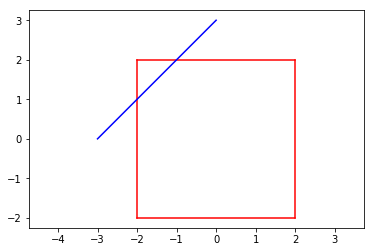

cu=cl=1, one blue bundle in between


TypeError: 'int' object is not callable

In [0]:
a=AllSegments()
a.addRedSq(2)
a.addBlue(-3,0,0,3)
a.plot()
a.sortFlags()
sweep(a.flags,10)
a.flags

(1, 1) (2, 2) red
(1, 1) (2, 3) red
 


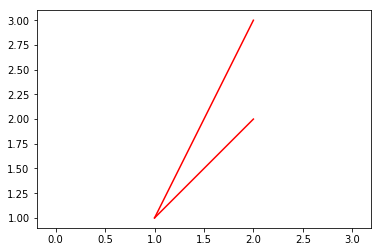

In [0]:
a=Bundle(makeSeg(1,2,3,4,0))
b=a
a.abv=Bundle(makeSeg(1,2,3,5,0))
b.abv.plot()

In [0]:
a=BundleList(5)
temp=a.lowest.abv
a.lowest.tree=1234
temp.bel.plot()

In [0]:
a=BundleList(10)
a2=[a.lowest.abv.abv]
a1=[a.lowest]
a.redBs=[a1,a2]
a1=None
a.redBs.plot()

In [0]:
a=Bundle(makeSeg(1,2,3,4,0))
b=Bundle(makeSeg(1,2,3,5,0))
a.abv=b
b.abv=Bundle(makeSeg(1,2,3,6,0))
a.abv.abv.plot()

In [0]:
a=Bundle(makeSeg(1,2,3,4,0))
b=a
a.setTo(None)
b.plot()

In [0]:
a=Bundle(makeSeg(1,2,3,4,0))
b=a
a=(Bundle(makeSeg(1,2,3,5,0)))
b.plot()

In [0]:
bl=BundleList(10)
flag1=makeFlag(1,2,3,4,1,0)
flag2=makeFlag(1,2,3,4,0,0)
bl.processFlag(flag2)
bl.processFlag(flag1)
bl.plot()
flag3=makeFlag(1,2,3,4,0,1)
bl.processFlag(flag3)
flag4=makeFlag(1,2,3,4,1,1)
bl.processFlag(flag4)
bl.plot()

In [0]:
s=AllSegments()
for i in range(0,10,2):
    s.addBlue(-i-1,i-2,0,0)
for i in range(11,1,-2):
    s.addBlue(-i-1,i-2,0,0)
b=Bundle(1)
s.sortFlags()
for i in range(5):
    b.insertB(s.blue[2*i])
b.plot()

In [0]:
for i in range(len(s.flags)):
    [node,x]=b.flagTest(s.flags[-i])
    if x!=0:
        s.flags[-i].prt()
        print(x)
        node.val.prt()
        print(' ')

In [0]:
a=2
b=5
a=b
b=4
a